In [ ]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline

In [1]:
import math
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry
from quetzal.model import stepmodel
from quetzal.io import excel

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

# Preparation of the LoS tables
## Saves a StepModel with shortest paths and LoS attributes for the road network
## Needs the road network

In [2]:
input_path = '../input_static/'
output_path = '../output/'
model_path = '../model/'

In [ ]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [3]:
sm = stepmodel.read_json(input_path + 'de_road_network')
ae = stepmodel.read_json(model_path + 'de_road_access_egress')
z = stepmodel.read_json(model_path + 'de_zones')

In [4]:
sm.zone_to_road = ae.zone_to_road
sm.centroids = ae.centroids
sm.zones = z.zones

## Generate LoS attribute time
The maxspeed column is based on OSM data that needs to be refined. The unit is km/h

In [ ]:
# Number of links (not length) with specified speeds
sm.road_links.hist(column='maxspeed', bins=50, figsize=(4,4))

In [ ]:
# Generate time for road links in seconds
# Manual calibration with Google maps (see below)
# shows that traffic flow is slower than the speed limits
road_speed_calibration = params['car']['speed_calibration']
sm.road_links["time"] = sm.road_links["length"] / 1000 / \
    (sm.road_links["maxspeed"] * road_speed_calibration) * 3600

In [ ]:
sm.road_links.sample(4)

### Alter road access/egress links

In [15]:
# There has been assigned a static time value in prep20
sm.zone_to_road.sample()

,a,b,direction,distance,speed,time,geometry
index,,,,,,,
598,299708759,DE91A,eggress,0,5,0,"LINESTRING (10.25532 52.30415, 10.25204 52.30650)"


In [16]:
# ASSUMPTION: Assign a time
sm.zone_to_road['time'] = params['access-egress_links']['time_road']

## Apply road pathfinder in order to generate LoS table

In [17]:
# Load OD pairs from volumes if available
od_set = None
try:
    v = stepmodel.read_json(model_path + 'de_volumes')
    od_set = set([tuple(l) for l in v.volumes[['origin', 'destination']].values.tolist()])
    print('Generated OD set with {} pairs'.format(len(od_set)))
except:
    print('The volumes file is not (yet) available')

Generated OD set with 160801 pairs


In [18]:
sm.step_road_pathfinder(all_or_nothing=True,
                        od_set=od_set)

In [19]:
sm.car_los.sample(3)

,origin,destination,time,path,node_path,link_path,ntlegs
155082,DEG0A,DEB13,16201.0,"[DEG0A, 1722581330, 1721505483, 929943627, 151...","[1722581330, 1721505483, 929943627, 15164786, ...","[rl_413985, rl_446702, rl_477985, rl_345566, r...","[(DEG0A, 1722581330), (307762151, DEB13)]"
150677,DEF0D,DEB1B,21734.0,"[DEF0D, 25076702, 25076790, 5730788622, 216996...","[25076702, 25076790, 5730788622, 21699647, 280...","[rl_462544, rl_429089, rl_204552, rl_462619, r...","[(DEF0D, 25076702), (1765034897, DEB1B)]"
58320,DE405,DE71E,23157.0,"[DE405, 1455170487, 2343331268, 29353517, 2935...","[1455170487, 2343331268, 29353517, 29353512, 3...","[rl_419589, rl_487756, rl_487754, rl_386938, r...","[(DE405, 1455170487), (3251511786, DE71E)]"


In [20]:
sm.car_los.shape

(160801, 7)

In [21]:
# Verify with Google maps routing
# Berlin (DE300) - Stade (DE939): 4h22m, 354km
# Berlin (DE300) - Stuttgart (DE111): 6h37m, 632km
# Berlin (DE300) - Stendal (DEE0D): 2h08m, 125km
# Stade - Stuttgart: 7h45m, 687km
# Stendal - Stuttgart: 6h11m, 574km
# Stendal - Stade: 3h22m, 231km
if manual:
    od = ['DE300', 'DE939', 'DE111', 'DEE0D']
    for _, row in sm.car_los.loc[(sm.car_los['origin'].isin(od)) &
                                 (sm.car_los['destination'].isin(od))].iterrows():
        print(row['origin'] + ' - ' + row['destination'] + ': '
              + str(np.round(row['time']/3600,1)) + ', '
              + str(int(sm.road_links.loc[row['link_path'], 'length'].sum()/1000)) + 'km')

DE111 - DE111: 0.0, 0km
DE111 - DE300: 6.8, 613km
DE111 - DE939: 7.7, 663km
DE111 - DEE0D: 7.2, 560km
DE300 - DE111: 6.8, 612km
DE300 - DE300: 0.0, 0km
DE300 - DE939: 4.2, 355km
DE300 - DEE0D: 2.6, 128km
DE939 - DE111: 7.6, 661km
DE939 - DE300: 4.2, 349km
DE939 - DE939: 0.0, 0km
DE939 - DEE0D: 3.6, 267km
DEE0D - DE111: 7.2, 557km
DEE0D - DE300: 2.6, 128km
DEE0D - DE939: 3.6, 267km
DEE0D - DEE0D: 0.0, 0km


array([[<AxesSubplot:title={'center':'time'}>]], dtype=object)

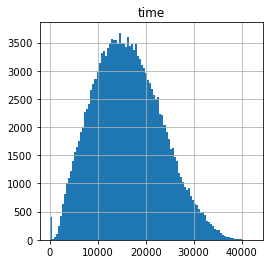

In [22]:
if manual: sm.car_los.hist(column='time', bins=100, figsize=(4,4))

In [23]:
# Drop inner-cell connections
sm.car_los = sm.car_los[sm.car_los['time']!=0]
sm.car_los.shape

(160400, 7)

## Add various attributes to LoS table

In [24]:
# Disaggregate into in-vehicle time and access/egress
sm.analysis_car_time()
sm.car_los.columns

Index(['origin', 'destination', 'time', 'path', 'node_path', 'link_path',
       'ntlegs', 'access_time', 'in_vehicle_time'],
      dtype='object')


In [25]:
# Add distances car
len_dict = sm.road_links['length'].to_dict()
sm.car_los['length'] = sm.car_los['link_path'].apply(lambda p: sum([len_dict[l] for l in p]))

In [26]:
# Add route_type = 'car' in car_los
sm.analysis_car_route_type()

In [27]:
sm.car_los['ntransfers'] = 0

## Add cost to LoS table

In [29]:
def monetary_cost(length, rf, vc, ac, al, ec, el, sf):
    """ calculate monetary cost of travelling one O-D realtion within the LoS table
    :param length: length of main leg in meter
    :param df: regression factor for length (to be calibrated beforehand)
    :param vc: distance-specific transport cost
    :param ac: access cost
    :param al: access link length (m)
    :param ec: egress cost
    :param el: egress link length (m)
    :param sf: sharing factor (e.g. occupancy factor of a car)
    :return: monetary cost"""
    return (math.pow(length, rf) * vc + ac * al + ec * el) / sf

In [30]:
# Load list of cost elements
cars = pd.read_csv(input_path + 'level_of_service/ADAC_2019_autokostenuebersicht_47085.csv')
cars.sample(4)

,fix_cost,repair_cost,var_cost,acquisition_cost,eur_per_month,ct_per_km,model,model.1
1424,126,105,161,552,944,75.5,V60 T5 Polestar Performance Momentum Geartronic,V60 T5 Polestar Performance Momentum Geartronic
1369,148,118,91,474,831,66.5,Model 3 Long Range AWD,Model 3 Long Range AWD
1464,122,81,150,377,730,58.4,XC40 T3,XC40 T3
1159,116,66,98,299,579,46.3,Rifter L1 1.5 BlueHDi 130 Active,Rifter L1 1.5 BlueHDi 130 Active


Take only perceived variable cost for distance-dependency.<br>
Assume monthly mileage of 15,000km / 12<br>
Additionally, there are fix cost which add up on every trip. Assume 3 trips per day as average.

In [31]:
# Prep
sm.car_los['price'] = 0
vc_car = params['car']['var_cost']
fix_car = params['car']['fix_cost']
parking_cost = params['parking_cost']
car_occ = params['car']['occupancy']

1.551890814081408
0.00011439257425742574


In [32]:
# ASSUMPTION: Average car occupancy is 1.5 in Germany
urb_dict = sm.zones['urbanisation'].to_dict()
sm.car_los['price'] = sm.car_los.apply(lambda df: monetary_cost(
    df['length'], 1, vc_car,
    0,0, # parking at home is for free
    parking_cost[urb_dict[df['destination']]], 1,
    car_occ) + fix_car, axis=1)

In [33]:
sm.car_los.sample(2)

,origin,destination,time,path,node_path,link_path,ntlegs,access_time,in_vehicle_time,length,route_types,route_type,ntransfers,accessibility,price
37461,DE245,DE717,9945,"[DE245, 306268450, 306253393, 480638786, 30626...","[306268450, 306253393, 480638786, 306264403, 4...","[rl_53660, rl_44462, rl_247282, rl_51273, rl_2...","[(DE245, 306268450), (848510869, DE717)]",600,9345,231429,"(car,)",car,0,1,19.201064
48672,DE268,DE40B,16257,"[DE268, 857381969, 2428188565, 262558486, 2428...","[857381969, 2428188565, 262558486, 2428188596,...","[rl_396698, rl_135586, rl_262099, rl_396709, r...","[(DE268, 857381969), (1607014826, DE40B)]",600,15657,397068,"(car,)",car,0,1,31.832978


<AxesSubplot:xlabel='length', ylabel='price'>

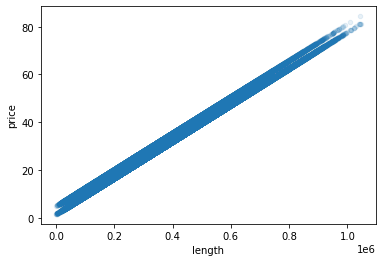

In [34]:
sm.car_los.plot.scatter(x='length', y='price', alpha=.1)

Instead of fix cost per trip, one can also assume ownership cost per hour of vehicle usage. This is also the approach chosen for the German federal governments transport study. In the methodical handbook gasoline cars have engine class weighted specific ownership cost of 0.71 EUR/h and diesel cars 0.99 EUR/h (other propulsion systems don't play a significant role). Multiplied with 2017's shares of gasoline and diesel cars (66.5%; 33.5%) this yields weighted average ownership cost of 0.8 EUR/h.

In [35]:
sm.car_los['price'] = sm.car_los['price'] - fix_car + \
    sm.car_los['time'].apply(lambda s: 0.8 * s / 3600)

<AxesSubplot:xlabel='length', ylabel='price'>

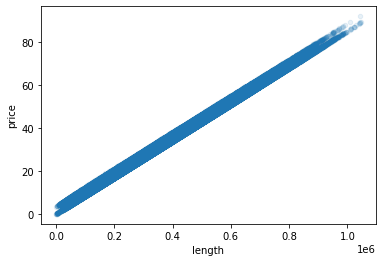

In [36]:
sm.car_los.plot.scatter(x='length', y='price', alpha=.1)

## Save model

In [37]:
# Ditch unneccessary columns
to_drop = ['alighting_links','alightings','all_walk','boarding_links','boardings',
           'footpaths','length_link_path','node_path','ntlegs','time_link_path','transfers',
           'pathfinder_session','gtime','reversed', 'broken_modes', 'path']
sm.car_los = sm.car_los.drop(to_drop, axis=1, errors='ignore')

In [38]:
# Make table smaller
cols = ['time', 'access_time', 'in_vehicle_time', 'length']
sm.car_los[cols] = sm.car_los[cols].astype(int)

In [39]:
sm.to_json(model_path + 'de_road_los',
           only_attributes=['car_los'], encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 34/34 [00:10<00:00,  3.19it/s]


In [40]:
# Also save road links with imputated maxspeeds
sm.road_links["time"] = sm.road_links["time"].astype(int)
sm.to_json(input_path + 'de_road_network', only_attributes=
           ['road_links', 'road_nodes', 'zones'], encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 34/34 [01:39<00:00,  2.93s/it]
